<div class="alert alert-block alert-success">
<h1><b>PROJET 10 - </b>Développez une preuve de concept
</h1>
<h2>Notebook Scripts</h2></div>

<img src="img_notebook/logo_dataspace.png" width="350" height="350">

## Table of Contents<hr>
[INTRODUCTION & PRESENTATION](#section_0)<br>
&emsp;[A - IMPORTATIONS](#section_0A)<br>
&emsp;[B - DATA COLLECTION & DESCRIPTION](#section_0B)<br><hr>
[PART 1 - DATA PREPARATION](#section_1)<br>
&emsp;[A - DATA GENERATOR](#section_1A)<br>
&emsp;[B - PERFORMANCE METRICS](#section_1B)<br>
&emsp;&emsp;[1 - Intersection over Union (IoU)](#section_1B1)<br>
&emsp;&emsp;[2 - Dice Coefficient](#section_1B2)<br>
&emsp;[C - LOSS FUNCTIONS](#section_1C)<hr>
[PART 2 - PROOF OF CONCEPT OF A STATE-OF-THE-ART SEMANTIC SEGMENTATION MODEL](#section_2)<br>
&emsp;[B - U-NET BASELINE MODEL](#section_2B)<br>
&emsp;&emsp;[1 - Presentation of U-NET model](#section_2B1)<br>
&emsp;&emsp;[2 - Building the model](#section_2B2)<br>
&emsp;&emsp;[3 - Training the model](#section_2B3)<br>
&emsp;&emsp;[4 - Visualization](#section_2B4)<br>
&emsp;[C - STATE-OF-THE-ART MODEL: HRNetV2 + OCR](#section_2C)<br>
&emsp;&emsp;[1 - Building the model](#section_2C1)<br>
&emsp;&emsp;[2 - Training the model](#section_2C2)<br>
&emsp;&emsp;[3 - Visualization](#section_2C3)<br>
&emsp;[D - PERFORMANCE SUMMARY](#section_2D)<br>
&emsp;[E - SOME RANDOM MASK PREDICTIONS](#section_2E)<hr>
[CONCLUSION](#section_00)

<h2><div class="alert alert-block alert-success" id="section_0">
INTRODUCTION & PRESENTATION</div></h2>

### Our mission

For this **proof of concept (POC)**, we're going back to "**Projet 8: Participez à la conception d'une voiture autonome**".<br>
The aim here is to carry out a **technological watch** in order to **find a recent method to improve the performance of the semantic segmentation model**.

We will use **the same Cityscapes dataset** (https://www.cityscapes-dataset.com/dataset-overview/) as in Projet 8.

We will use the **HRNetV2 + OCR model**, based on research articles **published on Arxiv in 2019, 2020 and 2021**.<br>
This model is still ranked #3 in the ranking of the Semantic Segmentation on Cityscapes test (https://paperswithcode.com/sota/semantic-segmentation-on-cityscapes).

### • Semantic Segmentation on Cityscapes test

<img src="img_notebook/Semantic_Segmentation_Cityscapes.png" width="900" height="900">

### Origin of the datasets

<img src="img_notebook/logo_cityscapes.png" width="250" height="250">

For this <b>semantic segmentation computer vision</b> challenge, we will use the <b>Cityscapes dataset</b> which focuses on semantic understanding of urban street scenes. This present a new large-scale dataset that contains a diverse set of stereo video sequences recorded in street scenes from 50 different cities, with high quality pixel-level annotations of <b>5 000 frames</b> in addition to a larger set of 20 000 weakly annotated frames.

We will use the 5 000 frames and the grouped classes into <b>8 main categories</b>, as follows.

#### • Class Definitions

|Group|Classes|
|---|---|
|<b>flat</b>|road · sidewalk · parking+ · rail track+|
|<b>human</b>|person* · rider*|
|<b>vehicle</b>|car* · truck* · bus* · on rails* · motorcycle* · bicycle* · caravan*+ · trailer*+|
|<b>construction</b>|building · wall · fence · guard rail+ · bridge+ · tunnel+|
|<b>object</b>|pole · pole group+ · traffic sign · traffic light|
|<b>nature</b>|vegetation · terrain|
|<b>sky</b>|sky|
|<b>void</b>|ground+ · dynamic+ · static+|

  \* *Single instance annotations are available. However, if the boundary between such instances cannot be clearly seen, the whole crowd/group is labeled together and annotated as group, e.g. car group.*
  <br>\+ *This label is not included in any evaluation and treated as void (or in the case of license plate as the vehicle mounted on).*

### What is semantic segmentation?

There are <b>three levels in the image analysis: Classification, Object detection and Segmentation</b>.<br><br>
<b>In semantic segmentation, each pixel is classified according to the class of the object it belongs to</b>. Here, we are talking about human, vehicule, constructon, sky, etc. Different objects of the same class are not distinguished (it's not instance segmentation).<br><br>
Image segmentation has many applications in medical imaging, <b>self-driving cars</b> (our case) and satellite imaging, just to name a few.<br>
Again, semantic segmentation is the task of classifying each pixel in an image from a predefined set of classes, and it's used by autonomous vehicles to understand their surroundings.<br>

<h3><div class="alert alert-block alert-info" id="section_0A">
A - IMPORTATIONS</div></h3>

In [1]:
%matplotlib inline

# Importation of Python modules and methods.
import os
import random
import warnings
from glob import glob
from math import ceil
from pprint import pprint

# Importation of Machine Learning libraries.
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Importation of an image segmentation third party library.
import tensorflow_advanced_segmentation_models as tasm

# Importation of TensorFlow/Keras functions or classes.
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ModelCheckpoint,
    ReduceLROnPlateau
)
from tensorflow.keras.layers import (
    Activation, 
    BatchNormalization, 
    concatenate, 
    Conv2D,
    Conv2DTranspose, 
    Dropout, 
    MaxPooling2D 
)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import (
    img_to_array,
    load_img,
    plot_model, 
    Sequence,
)

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'  # Only warning and error information is displayed.

<h3><div class="alert alert-block alert-info" id="section_0B">
B - DATA COLLECTION & DESCRIPTION</div></h3>

The datasets we have, from Cityscapes, contain only <b>PNG images</b> with <b>size 1024 x 2048</b>.<br>
For <b>masks</b>, we are going to use the <b>gtFine_labelIds</b> ones.<br>
In total, we have <b>5 000 images</b> from different cities, and the same amount of respective masks.<br>
The directories and files are organized as follows:

#### Directory structure

```
datasets
│
└───images
│   │
│   └───test
│       └───berlin
│       |   └───berlin_000000_000019_leftImg8bit.png
│       |   └───berlin_000001_000019_leftImg8bit.png
│       |   └───...
│       └───bielefeld
│       └───...
│   └───train
│       └───...
│   └───val 
│       └───...
└───masks
    │
    └───test
        └───berlin
        |   └───berlin_000000_000019_gtFine_color.png
        |   └───berlin_000000_000019_gtFine_instanceIds.png
        |   └───berlin_000000_000019_gtFine_labelIds.png
        |   └───berlin_000000_000019_gtFine_polygons.json
        |   └───...
        └───bielefeld
        └───...
    └───train
        └───...
    └───val 
        └───...
```

In [2]:
def input_paths(_input='images', _type='train', is_aug=False):
    """Function to get the list of all images or masks collected 
    inside all the directories and sub-directories in the datasets, 
    excluding or not the augmented images."""
    if _input == 'images':
        if is_aug == True:
            input_paths_list = sorted(
                glob(f'datasets/{_input}/{_type}/**/*.png', recursive = True))
        elif is_aug == False:
            input_paths_list = sorted(
                glob(f'datasets/{_input}/{_type}/[!_]**/*.png', recursive = True))
    if _input == 'masks':
        # Getting only the labelIds masks (and the augmented masks if wanted).
        input_paths_list = sorted(
            glob(f'datasets/{_input}/{_type}/**/*gtFine_labelIds.png', recursive = True))
        if is_aug == True:
            aug_masks = sorted(
                glob(f'datasets/{_input}/{_type}/_data_aug/*.png', recursive = True))
            input_paths_list = sorted(input_paths_list + aug_masks)
    return input_paths_list

In [3]:
# Number of images, and examples, in the training dataset.
image_train_paths = input_paths(_input='images', _type='train')
print(f'\033[34;1mIn all directories the number of train images is \
{len(image_train_paths)}.\033[34;0m')
print('\n\033[34;1mFirst elements in image_train_paths list:\033[34;0m')
pprint(image_train_paths[:5])

# Number of masks, and examples, in the training dataset.
mask_train_paths = input_paths(_input='masks', _type='train')
print(f'\n\033[34;1mIn all directories the number of train masks is \
{len(mask_train_paths)}.\033[34;0m')
print('\n\033[34;1mFirst elements in mask_train_paths list:\033[34;0m')
pprint(mask_train_paths[:5])

In all directories the number of train images is 2975.

First elements in image_train_paths list:
['datasets/images/train/aachen/aachen_000000_000019_leftImg8bit.png',
 'datasets/images/train/aachen/aachen_000001_000019_leftImg8bit.png',
 'datasets/images/train/aachen/aachen_000002_000019_leftImg8bit.png',
 'datasets/images/train/aachen/aachen_000003_000019_leftImg8bit.png',
 'datasets/images/train/aachen/aachen_000004_000019_leftImg8bit.png']

In all directories the number of train masks is 2975.

First elements in mask_train_paths list:
['datasets/masks/train/aachen/aachen_000000_000019_gtFine_labelIds.png',
 'datasets/masks/train/aachen/aachen_000001_000019_gtFine_labelIds.png',
 'datasets/masks/train/aachen/aachen_000002_000019_gtFine_labelIds.png',
 'datasets/masks/train/aachen/aachen_000003_000019_gtFine_labelIds.png',
 'datasets/masks/train/aachen/aachen_000004_000019_gtFine_labelIds.png']


In [4]:
# Number of images, and examples, in the validation dataset.
image_val_paths = input_paths(_input='images', _type='val')
print(f'\033[34;1mIn all directories the number of validation images is \
{len(image_val_paths)}.\033[34;0m')
print('\n\033[34;1mFirst elements in image_val_paths list:\033[34;0m')
pprint(image_val_paths[:5])

# Number of masks, and examples, in the validation dataset.
mask_val_paths = input_paths(_input='masks', _type='val')
print(f'\n\033[34;1mIn all directories the number of validation masks is \
{len(mask_val_paths)}.\033[34;0m')
print('\n\033[34;1mFirst elements in mask_val_paths list:\033[34;0m')
pprint(mask_val_paths[:5])

In all directories the number of validation images is 500.

First elements in image_val_paths list:
['datasets/images/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png',
 'datasets/images/val/frankfurt/frankfurt_000000_000576_leftImg8bit.png',
 'datasets/images/val/frankfurt/frankfurt_000000_001016_leftImg8bit.png',
 'datasets/images/val/frankfurt/frankfurt_000000_001236_leftImg8bit.png',
 'datasets/images/val/frankfurt/frankfurt_000000_001751_leftImg8bit.png']

In all directories the number of validation masks is 500.

First elements in mask_val_paths list:
['datasets/masks/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png',
 'datasets/masks/val/frankfurt/frankfurt_000000_000576_gtFine_labelIds.png',
 'datasets/masks/val/frankfurt/frankfurt_000000_001016_gtFine_labelIds.png',
 'datasets/masks/val/frankfurt/frankfurt_000000_001236_gtFine_labelIds.png',
 'datasets/masks/val/frankfurt/frankfurt_000000_001751_gtFine_labelIds.png']


In [5]:
# Number of images, and examples, in the test dataset.
image_test_paths = input_paths(_input='images', _type='test')
print(f'\033[34;1mIn all directories the number of test images is \
{len(image_test_paths)}.\033[34;0m')
print('\n\033[34;1mFirst elements in image_test_paths list:\033[34;0m')
pprint(image_test_paths[:5])

# Number of masks, and examples, in the test dataset.
mask_test_paths = input_paths(_input='masks', _type='test')
print(f'\n\033[34;1mIn all directories the number of test masks is \
{len(mask_test_paths)}.\033[34;0m')
print('\n\033[34;1mFirst elements in mask_test_paths list:\033[34;0m')
pprint(mask_test_paths[:5])

In all directories the number of test images is 1525.

First elements in image_test_paths list:
['datasets/images/test/berlin/berlin_000000_000019_leftImg8bit.png',
 'datasets/images/test/berlin/berlin_000001_000019_leftImg8bit.png',
 'datasets/images/test/berlin/berlin_000002_000019_leftImg8bit.png',
 'datasets/images/test/berlin/berlin_000003_000019_leftImg8bit.png',
 'datasets/images/test/berlin/berlin_000004_000019_leftImg8bit.png']

In all directories the number of test masks is 0.

First elements in mask_test_paths list:
[]


### Unfortunately, there are only black masks in the test data, as the data is not public. So we got rid of them.<br>We will therefore not use this test dataset to compare the two models and we will stick to the validation results during learning.

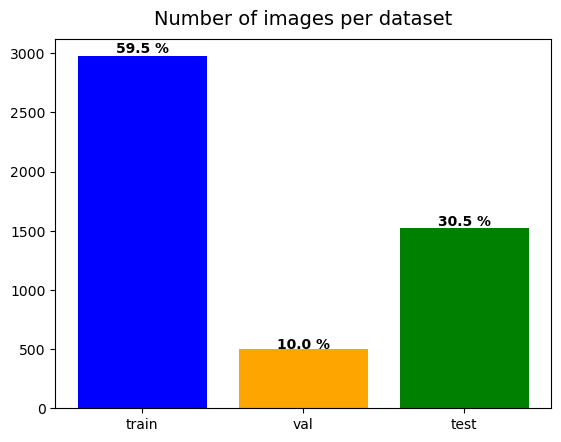

In [6]:
# Bar plot of the number of images per type of dataset.
fig, ax = plt.subplots()
images_cat = ['train', 'val', 'test']
images_num = [len(image_train_paths), 
              len(image_val_paths), 
              len(image_test_paths)]
colors_list = ['blue', 'orange', 'green']
images = plt.bar(images_cat, images_num, color=colors_list)
for img in images:
    height = img.get_height()
    width = img.get_width()
    x, y = img.get_xy()
    ax.text(x + width / 2, y + height * 1.01,
            s=f"{height * 100 / sum(images_num)} %", 
            ha='center', weight='bold')
plt.title('Number of images per dataset', size=14, pad=10)
plt.show()

Image shape: (1024, 2048, 3)
Mask shape: (1024, 2048)


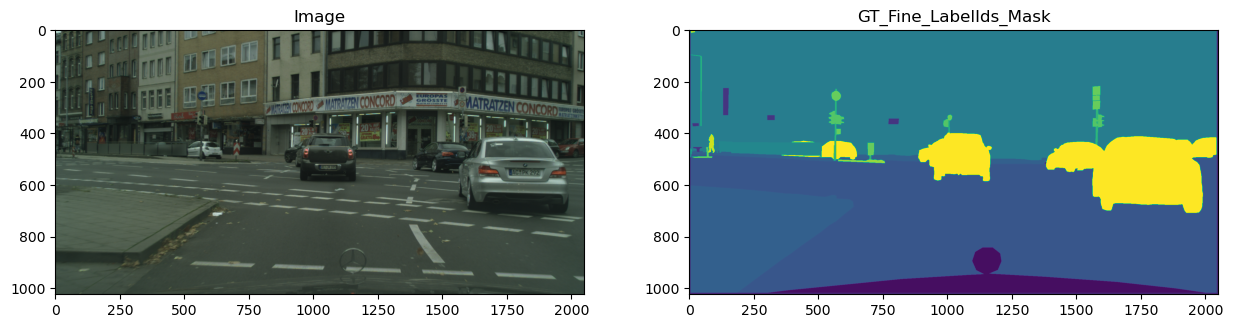

In [7]:
# Visualizing an image and its mask.
i = 3
test_image = img_to_array(
    load_img(image_train_paths[i])) / 255.0
test_mask = img_to_array(
    load_img(mask_train_paths[i], color_mode="grayscale"))
test_mask = np.squeeze(test_mask)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Image')
ax.imshow(test_image)

ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title('GT_Fine_LabelIds_Mask')
ax1.imshow(test_mask)

# Checking the shape of the image and the mask.
print(f"\033[34;1mImage shape: {test_image.shape}")
print(f"Mask shape: {test_mask.shape}")

<h2><div class="alert alert-block alert-success" id="section_1">
PART 1 - DATA PREPARATION</div></h2>

#### In this POC we won't use data augmentation. On the contrary, we will reduce the dataset size, because the computer time complexity and the memory usage must be limited so that my computer is able to process the model training.

<h3><div class="alert alert-block alert-info" id="section_1A">
A - DATA GENERATOR</div></h3>

The <b>manipulation of a large dataset</b> will be easier with the construction of a data generator as a python class. This reduce the need of high memory space. This generator creates data in batches to feed it to our network for training.<br><br>
For that, we will use the <b>*Sequence* class in Keras</b>, that handles all the multi-threading and parallelization behind the scene by fetching the batches ahead of time using multiple CPU cores.<br>
It generates the dataset on multiple cores in real time and feed it right away to our deep learning models.

In [8]:
# Defining variables for the rest of the modelling.
batch_size = 3   # for training and validation. Couldn't be bigger for the HRNet + OCR model training.
IMG_HEIGHT = 192 # instead of the original 1024, to reduce time complexity.
IMG_WIDTH = 384  # instead of the original 2048, to reduce time complexity.
IMG_CHANNELS = 3 # RGB
n_classes = 8    # class colors.

In [9]:
# Dict of the 8 categories, as keys, and a list of corresponding class ids as values.
cat_dict = {'void': [0, 1, 2, 3, 4, 5, 6], 
            'flat': [7, 8, 9, 10],
            'construction': [11, 12, 13, 14, 15, 16],
            'object': [17, 18, 19, 20],
            'nature': [21, 22],
            'sky': [23],
            'human': [24, 25],
            'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]  # -1 is for the license plate.
           }

In [10]:
class ImgSeqGenerator(Sequence):
    """Helper to iterate over the data, to load & vectorize batches of data.
    """

    def __init__(self, x_set, y_set, batch_size, n_classes=8, shuffle=False):
        """Generator constructor: parameters."""
        self.x_set = x_set
        self.y_set = y_set
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Number of batches that this generator is supposed to produce, per epoch."""
        return ceil(len(self.x_set) / self.batch_size)

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.x_set))
        if self.shuffle == True:
            np.random.seed(53)
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, idx):  # allows the instance to use the [] (indexer) operator.
        """Returns tuple (image, mask) corresponding to batch number.
        Generating one batch of data."""
        # Batch size list of random integers in the range of the size of the image list length.
        current_batch_id = self.indexes[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_x, batch_y = [], []
        # Generating batch_x and batch_y.
        # Iterate over indexes.
        for i in current_batch_id:
            # Loading image, setting target size, converting to array and normalizing. 
            _image = img_to_array(
                load_img(f'{self.x_set[i]}', target_size=(
                    IMG_HEIGHT, IMG_WIDTH))) / 255.
            # Storing image.
            batch_x.append(_image)
            # Loading original mask, setting target size and converting to array. 
            msk = img_to_array(
                load_img(f'{self.y_set[i]}', color_mode="grayscale", target_size=(
                    IMG_HEIGHT, IMG_WIDTH)))
            msk = np.squeeze(msk, axis=-1)
            mask = np.zeros((msk.shape[0], msk.shape[1], self.n_classes))
            # Transforming the 34 original classes from the original mask to 8 categories.
            for j in range(-1, 34):
                if j in cat_dict['void']:
                    mask[:, :, 0] = np.logical_or(mask[:, :, 0], (msk == j))
                elif j in cat_dict['flat']:
                    mask[:, :, 1] = np.logical_or(mask[:, :, 1], (msk == j))
                elif j in cat_dict['construction']:
                    mask[:, :, 2] = np.logical_or(mask[:, :, 2], (msk == j))
                elif j in cat_dict['object']:
                    mask[:, :, 3] = np.logical_or(mask[:, :, 3], (msk == j))
                elif j in cat_dict['nature']:
                    mask[:, :, 4] = np.logical_or(mask[:, :, 4], (msk == j))
                elif j in cat_dict['sky']:
                    mask[:, :, 5] = np.logical_or(mask[:, :, 5], (msk == j))
                elif j in cat_dict['human']:
                    mask[:, :, 6] = np.logical_or(mask[:, :, 6], (msk == j))
                elif j in cat_dict['vehicle']:
                    mask[:, :, 7] = np.logical_or(mask[:, :, 7], (msk == j))
            mask = np.resize(mask, (IMG_HEIGHT, IMG_WIDTH, self.n_classes))
            # Storing mask.
            batch_y.append(mask)

        return np.array(batch_x), np.array(batch_y)

### • Reducing the original dataset size

In [11]:
# Dividing by 3 (divider) the original size of the training image dataset.
random.seed(53)
divider = 4
kti = round(len(image_train_paths) / divider)
image_train_paths_select = random.choices(image_train_paths, k=kti)
print(f"Number of training images: {len(image_train_paths_select)}\n")
print(f"First 3 ramdom examples: \n{image_train_paths_select[:4]}\n\n")

# Dividing by 3 (divider) the original size of the training mask dataset.
random.seed(53)
ktm = round(len(mask_train_paths) / divider)
mask_train_paths_select = random.choices(mask_train_paths, k=ktm)
print(f"Number of training masks: {len(mask_train_paths_select)}\n")
print(f"First 3 ramdom examples: \n{mask_train_paths_select[:4]}\n\n")

# Dividing by 3 (divider) the original size of the validation image dataset.
random.seed(53)
kvi = round(len(image_val_paths) / divider)
image_val_paths_select = random.choices(image_val_paths, k=kvi)
print(f"Number of validation images: {len(image_val_paths_select)}\n")
print(f"First 3 ramdom examples: \n{image_val_paths_select[:4]}\n\n")

# Dividing by 3 (divider) the original size of the validation mask dataset.
random.seed(53)
kvm = round(len(mask_val_paths) / divider)
mask_val_paths_select = random.choices(mask_val_paths, k=kvm)
print(f"Number of validation masks: {len(mask_val_paths_select)}\n")
print(f"First 3 ramdom examples: \n{mask_val_paths_select[:4]}")

Number of training images: 744

First 3 ramdom examples: 
['datasets/images/train/monchengladbach/monchengladbach_000000_009615_leftImg8bit.png', 'datasets/images/train/ulm/ulm_000032_000019_leftImg8bit.png', 'datasets/images/train/hamburg/hamburg_000000_088783_leftImg8bit.png', 'datasets/images/train/strasbourg/strasbourg_000001_016376_leftImg8bit.png']


Number of training masks: 744

First 3 ramdom examples: 
['datasets/masks/train/monchengladbach/monchengladbach_000000_009615_gtFine_labelIds.png', 'datasets/masks/train/ulm/ulm_000032_000019_gtFine_labelIds.png', 'datasets/masks/train/hamburg/hamburg_000000_088783_gtFine_labelIds.png', 'datasets/masks/train/strasbourg/strasbourg_000001_016376_gtFine_labelIds.png']


Number of validation images: 125

First 3 ramdom examples: 
['datasets/images/val/lindau/lindau_000041_000019_leftImg8bit.png', 'datasets/images/val/munster/munster_000119_000019_leftImg8bit.png', 'datasets/images/val/frankfurt/frankfurt_000001_066092_leftImg8bit.png', '

In [12]:
# Generators for training and validation data.
# Creating instances of the ImgSeqGenerator class.
train_generator = ImgSeqGenerator(
    image_train_paths_select, mask_train_paths_select, batch_size, shuffle=True)
val_generator = ImgSeqGenerator(
    image_val_paths_select, mask_val_paths_select, batch_size, shuffle=True)

In [13]:
print(f"Number of batches of {batch_size} training images: \
{len(train_generator)}")
print(f"Number of batches of {batch_size} validation images: \
{len(val_generator)}")

Number of batches of 3 training images: 248
Number of batches of 3 validation images: 42


In [14]:
# Checking data shape of the first training batch.
x_train, y_train = train_generator[0]
print('Data shape of the first training batch (x and y): ', x_train.shape, y_train.shape)

Data shape of the first training batch (x and y):  (3, 192, 384, 3) (3, 192, 384, 8)


In [15]:
# Checking data shape of the first validation batch.
x_val, y_val = val_generator[0]
print('Data shape of the first validation batch (x and y): ', x_val.shape, y_val.shape)

Data shape of the first validation batch (x and y):  (3, 192, 384, 3) (3, 192, 384, 8)


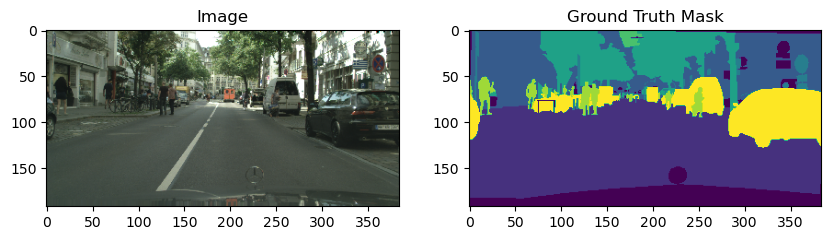

In [16]:
# Getting the first image and ground truth mask from the training data.
x_train, y_train = train_generator[0]
img = x_train[0]
mask = y_train[0]

# Converting the one-hot encoded mask back to its class label form.
mask = np.argmax(mask, axis=-1)

# Plotting the image and ground truth mask.
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title('Image')
ax[1].imshow(mask)
ax[1].set_title('Ground Truth Mask')
plt.show()

<h3><div class="alert alert-block alert-info" id="section_1B">
B - PERFORMANCE METRICS</div></h3>

<b>To evaluate the performance of the Deep Learning models</b> we are going to build for <b>Semantic Segmentation</b>, we will use 2 different metrics, both quite similar.

Our prediction output shape, the mask, matches the input's spatial resolution (width and height) with a channel depth equivalent to the number of possible classes to be predicted. Each channel consists of a binary mask which labels areas where a specific class is present.

<b>Accuracy is here irrelevant</b>. Pixel accuracy can provide misleading results when the class representation is small within the image, as the measure will be biased in mainly reporting how well you identify negative case (ie. where the class is not present).

Instead, we will use here the <b>IoU and the Dice Coefficient</b> that suit better for semantic segmentation.

<h4><div class="alert alert-block alert-warning" id="section_1B1">
1 - Intersection over Union (IoU)</div></h4>

<b>The Intersection over Union (IoU), or the Jaccard index</b>, quantifies the percent overlap between the target mask and our prediction output.<br>Said another way, it is <b>the ratio of the intersection of the pixelwise classification results with the ground truth (the mask), to their union</b>.

The IoU score is calculated for each class separately and then averaged over all classes to provide a global, <b>mean IoU score</b> of our semantic segmentation prediction. In fact, <b>we will use this only metric during training to compare the two models</b>.

This metric ranges from 0–1 (0–100%) with 0 signifying no overlap and 1 signifying perfectly overlapping segmentation.

<img src="img_notebook/IoU.png" width="350" height="350">

#### • Formula:

<img src="img_notebook/IoU_formula.png" width="350" height="350">

<h4><div class="alert alert-block alert-warning" id="section_1B2">
2 - Dice Coefficient</div></h4>

The <b>Sørensen–Dice coefficient or Dice Coefficient</b> is simply the count of the similar pixels (taking intersection, present in both images) in both images we are comparing and multiplied by 2, the total divided by the total pixels in both images.<br>
Or, to put it simply, it's 2 * the Area of Overlap divided by the total number of pixels in both images.

As for IoU, this metric ranges from 0–1 (0–100%) with 0 signifying no overlap and 1 signifying perfectly overlapping segmentation.

<img src="img_notebook/Dice.png" width="300" height="300">

#### • Formula:

<img src="img_notebook/Dice_formula.png" width="200" height="200">

This metric is <b>closely related to the IoU coefficient</b> we just saw.<br>
Here <b>we will use this metric in the loss function during training</b>.

<h3><div class="alert alert-block alert-info" id="section_1C">
C - LOSS FUNCTIONS</div></h3>

For the <b>loss function</b>, we will use the <b>Dice loss</b> because it **performs well at class imbalanced problems by design**, instead of the categorical cross entropy that can be seen more as a proxy, easier to maximize. It's based on the Dice coefficient, using 1 - Dice to minimize.

<h2><div class="alert alert-block alert-success" id="section_2">
PART 2 - PROOF OF CONCEPT OF A STATE-OF-THE-ART SEMANTIC SEGMENTATION MODEL</div></h2>

<h3><div class="alert alert-block alert-info" id="section_2A">
A - UTILS FUNCTIONS TO BUILD AND VISUALIZE OUR MODELS</div></h3>

## Training function to train, compile, make callbacks, fit and save models

In [17]:
def training_model(model, name, epochs, train_gen, val_gen, 
                   optimizer, loss, metrics):
    
    """Configuring the model for training. Compiling, callbacks, fitting and saving.
    """
    # Restoring the weights if existed.
    try:
        model.load_weights(f'./checkpoint/{name}/{name}')
        print(f"\033[34;1mStarting from previous checkpoint ./checkpoint/{name}/{name}.\n\033[34;0m")
    except: 
        print("\033[34;1mNo previous checkpoint found. Starting from scratch...\n\033[34;0m")
    
    # Compiling the model.
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # Callbacks.
    # Defining EarlyStopping callback.
    earlystop = EarlyStopping(monitor='val_loss', 
                              patience=3,
                              restore_best_weights=True
                             )
    # Defining ModelCheckpoint callback. Best weights are saved at the end of every epoch, 
    # if it's the best seen so far.
    checkpoint_path = f"checkpoint/{name}/{name}"
    checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                 monitor='val_loss',
                                 save_weights_only=True,
                                 save_best_only=True)

    print(f"\033[34;1mTraining the model named '{name}':\n\033[34;0m")

    # Training the model, doing validation at the end of each epoch.
    # We use here fit() with a generator to deal with huge dataset that 
    # couldn't fit into memory.
    hist_model = model.fit(x=train_gen, 
                           epochs=epochs, 
                           verbose=2, 
                           callbacks=[earlystop, checkpoint], 
                           validation_data=val_gen, 
                           steps_per_epoch=len(train_gen), 
                           validation_steps=len(val_gen),
                           workers=10)  # use_multiprocessing not working !
    
    # Saving the entire model as a SaveModel. This saves the model architecture, weights,
    # information about the training process such as the state of the optimizer, etc.
    model.save(f"models/{name}")
    
    return hist_model

## Function to vizualize performance metric evolution

In [18]:
def metrics_visu(hist, metric_name):
    """Visualization of the Training and Validation with the performance metric."""
    metric = hist.history[metric_name]
    val_metric = hist.history[f'val_{metric_name}']
    epochs = range(1, len(metric) + 1)

    plt.plot(epochs, metric, '-', label=f'Training {metric_name}')
    plt.plot(epochs, val_metric, ':', label=f'Validation {metric_name}')
    plt.title(f'Training and Validation {metric_name} performance metric')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

## Function to vizualize loss function evolution

In [19]:
def loss_visu(hist, loss_name):
    """Visualization of the Training and Validation with the Loss function."""
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, '-', label=f'Training {loss_name}')
    plt.plot(epochs, val_loss, ':', label=f'Validation {loss_name}')
    plt.title(f'Training and Validation {loss_name} loss function')
    plt.xlabel('Epoch')
    plt.ylabel(loss_name)
    plt.legend()
    plt.show()

## Functions to build our U-NET model

In [20]:
num_filters = 32  # for modelling our homemade U-NET model.

In [21]:
# Helper functions to allow us to ensemble our U-NET model block operations easily and simply.

def encoder_block(input_tensor, num_filters, 
                  kernel_init='he_normal', pooling=True):
    """Encoder block: 1 convolutional layer, 1 batch normalization, 1 convolutional layer,
    1 batch normalization and 1 max pooling layer (or not if it's the last encoder layer).
    """
    conv = Conv2D(filters=num_filters, kernel_size=(3, 3), strides=(1, 1),
                  padding='same', use_bias=False, kernel_initializer=kernel_init)(input_tensor)
    # BatchNormalization is good for standardizing, stabilizing, speeding up the training
    # and reducing generalization error. No need of dropout anymore. No need of bias vector.
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(num_filters, (3, 3),  padding='same', use_bias=False, 
                  kernel_initializer=kernel_init)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    if pooling == True:
        pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv)
        return pool, conv
    return conv

def decoder_block(input_tensor, num_filters, concat_tensor, 
                  dropout=0.1, kernel_init='he_normal'):
    """Decoder block: 1 transposed convolution layer (with concatenation for skip connections), 
    1 convolutional layer, 1 dropout and 1 convolutional layer.
    """
    decoder = Conv2DTranspose(filters=num_filters, kernel_size=(2, 2), 
                              strides=(2, 2), padding='same')(input_tensor)  # strides are here stretching size.
    decoder = concatenate([decoder, concat_tensor])
    decoder = Conv2D(filters=num_filters, kernel_size=(3, 3), 
                     strides=(1, 1), padding='same', 
                     activation='relu', kernel_initializer=kernel_init)(decoder)
    decoder = Dropout(rate=dropout, seed=52)(decoder)
    decoder = Conv2D(num_filters, (3, 3), activation='relu', 
                     kernel_initializer=kernel_init, 
                     padding='same')(decoder)
    return decoder

<h3><div class="alert alert-block alert-info" id="section_2B">
B - U-NET BASELINE MODEL</div></h3>

For the **baseline model**, we use the model we created and retained in **project 8**: our **homemade U-NET model**.

<h4><div class="alert alert-block alert-warning" id="section_2B1">
1 - Presentation of U-NET model</div></h4>

The U-Net is a convolutional network architecture, designed by Olaf Ronneberger, Philipp Fischer and Thomas Brox, for biomedical image segmentation, at the Computer Science Department of the University of Freiburg.<br><b>U-NET is based upon the "fully convolutional" architecture</b>, and "consists of a contracting path to capture context and a symmetric expanding path that enables precise localization."

<b>In short, in the downslope of the U-NET (contracting path), the network learns to classify the objects with the features found.<br>
In the upslope (expansive path) the network try to localize the objects in the picture</b>.

Pooling layers helps the architecture create feature hierarchies, but also causes loss of localized information. Skip connections preserve and forward this information to deeper layers by way of bypassing the pooling layers.

One of the changes, from the original architecture, that will be included in this structure is using the value of <b>padding as "same"</b>.<br>
Also, since the concept of <b>batch normalization</b> was introduced in 2016, the original architecture did not use this aspect. But, our model implementation will include batch normalization as it yields the best results in most cases.

Our <b>image shapes</b> must be <b>divisible by at least 16</b>. Since we are using four max-pooling layers during the down-sampling procedure, we don't want to encounter the divisibility of any odd number shapes.

#### Example of U-NET architecture : 

<img src="img_notebook/U-NET2.png" width="400" height="400">

<h4><div class="alert alert-block alert-warning" id="section_2B2">
2 - Building the model</div></h4>

#### Building of our homemade U-NET architecture with the help of utils functions.

In [22]:
def unet_archi():
    """Building the U-NET model architecture."""
    K.clear_session()  # clearing the RAM.

    # Inputs (images).
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image_input')

    # Encoder layers.
    conv_pool1, conv1 = encoder_block(input_tensor=inputs, num_filters=num_filters)
    conv_pool2, conv2 = encoder_block(input_tensor=conv_pool1, num_filters=num_filters*2)
    conv_pool3, conv3 = encoder_block(input_tensor=conv_pool2, num_filters=num_filters*4)
    conv_pool4, conv4 = encoder_block(input_tensor=conv_pool3, num_filters=num_filters*8)

    # Center or intermediate layer, with no max pooling.
    conv5 = encoder_block(
        input_tensor=conv_pool4, num_filters=num_filters*16, pooling=False)

    # Decoder layers.
    decoder1 = decoder_block(input_tensor=conv5, num_filters=num_filters*8, 
                             concat_tensor=conv4, dropout=0.2)
    decoder2 = decoder_block(input_tensor=decoder1, num_filters=num_filters*4, 
                             concat_tensor=conv3, dropout=0.2)
    decoder3 = decoder_block(input_tensor=decoder2, num_filters=num_filters*2, 
                             concat_tensor=conv2, dropout=0.1)
    decoder4 = decoder_block(input_tensor=decoder3, num_filters=num_filters, 
                             concat_tensor=conv1, dropout=0.1)

    # Adding a per-pixel classification layer and outputting the mask of the input image.
    # The output classes are mutually exclusive, we can only choose one, then we use a softmax function.
    # A pixel can't share a label. So sigmoid won't be use.
    outputs = Conv2D(filters=n_classes, kernel_size=(1, 1), padding='same',
                     activation='softmax', name='mask_output')(decoder4)

    # Defining the model.
    unet_model = Model(inputs=inputs, outputs=outputs, name='UNET_model')

    return unet_model

In [23]:
# Building a U-NET model.
unet_model = unet_archi()
# Summary of the model.
unet_model.summary()

Metal device set to: Apple M1 Pro
Model: "UNET_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 192, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 384, 32  864         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 192, 384, 32  128        ['conv2d[0][0]']                 
 alization)                     )                      

 batch_normalization_9 (BatchNo  (None, 12, 24, 512)  2048       ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 12, 24, 512)  0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 24, 48, 256)  524544     ['activation_9[0][0]']           
 ose)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 24, 48, 512)  0           ['conv2d_transpose[0][0]',       
                                                                  'activation_7[0][0]']           
          

<h4><div class="alert alert-block alert-warning" id="section_2B3">
3 - Training the model</div></h4>

In [24]:
# Definining some parameters for the models.
# Gradient descent with momentum optimizer that accelerates gradient descent 
# in the relevant direction and dampens oscillations.
optimizer = SGD(learning_rate=0.02, momentum=0.9)
# Dice Loss function.
loss = tasm.losses.DiceLoss()
# Mean IoU performance metric, with a 0.5 threshold.
mIoU = tasm.metrics.IOUScore(threshold=0.5)
# Number of epochs.
epochs = 30

In [25]:
%%time
# Training the U-NET baseline model.
hist_model_unet = training_model(
    model=unet_model, name='model_unet', 
    epochs=epochs,
    train_gen=train_generator, 
    val_gen=val_generator,
    optimizer=optimizer,
    loss=loss, 
    metrics=[mIoU]
)

No previous checkpoint found. Starting from scratch...

Training the model named 'model_unet':

Epoch 1/30
248/248 - 51s - loss: 0.6782 - iou_score: 0.2547 - val_loss: 0.7432 - val_iou_score: 0.1898 - 51s/epoch - 205ms/step
Epoch 2/30
248/248 - 48s - loss: 0.4961 - iou_score: 0.4078 - val_loss: 0.5042 - val_iou_score: 0.4019 - 48s/epoch - 192ms/step
Epoch 3/30
248/248 - 48s - loss: 0.4349 - iou_score: 0.4671 - val_loss: 0.4465 - val_iou_score: 0.4536 - 48s/epoch - 192ms/step
Epoch 4/30
248/248 - 47s - loss: 0.4049 - iou_score: 0.4971 - val_loss: 0.4508 - val_iou_score: 0.4555 - 47s/epoch - 191ms/step
Epoch 5/30
248/248 - 48s - loss: 0.3819 - iou_score: 0.5204 - val_loss: 0.4345 - val_iou_score: 0.4659 - 48s/epoch - 193ms/step
Epoch 6/30
248/248 - 48s - loss: 0.3643 - iou_score: 0.5393 - val_loss: 0.4275 - val_iou_score: 0.4637 - 48s/epoch - 193ms/step
Epoch 7/30
248/248 - 48s - loss: 0.3537 - iou_score: 0.5504 - val_loss: 0.3984 - val_iou_score: 0.4946 - 48s/epoch - 193ms/step
Epoch 8/

INFO:tensorflow:Assets written to: models/model_unet/assets


INFO:tensorflow:Assets written to: models/model_unet/assets


CPU times: user 11min 9s, sys: 1min 6s, total: 12min 15s
Wall time: 8min 53s


<h4><div class="alert alert-block alert-warning" id="section_2B4">
4 - Visualization</div></h4>

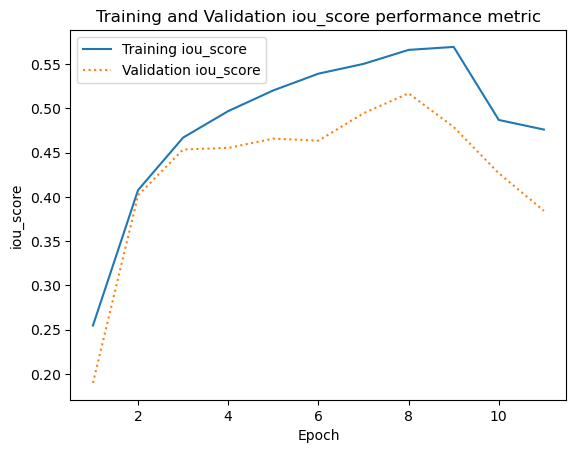

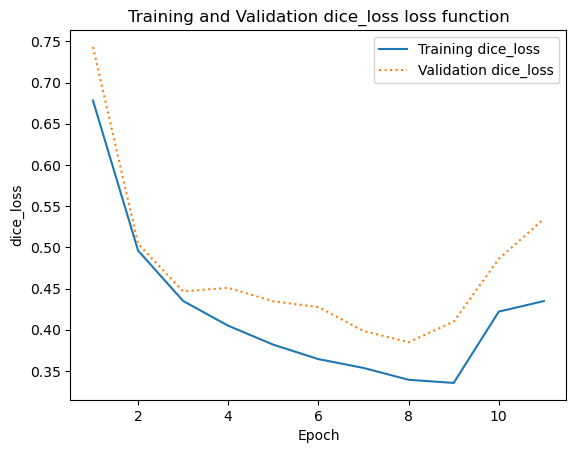

In [26]:
# Visualization of the Training and Validation with the iou_score as performance metric.
metrics_visu(hist_model_unet, 'iou_score')
# Visualization of the Training and Validation with the Dice Loss function.
loss_visu(hist_model_unet, 'dice_loss')

<h3><div class="alert alert-block alert-info" id="section_2C">
C - STATE-OF-THE-ART MODEL: HRNetV2 + OCR</div></h3>

### • HRNet

**High-Resolution Net (HRNet)** was first developed for human pose estimation, but works very well on all computer vision tasks, especially on tasks where **pixel-level accuracy** is important, such as semantic segmentation, face alignment and pose estimation.<br><br>
HRNet is **able to maintain high resolution representations throughout the process**.<br>
We start from a high resolution convolution stream, gradually add high to low resolution convolution streams one by one, and connect the multi-resolution streams in parallel. This leads not only to **semantically strong** representations but also to **spatially accurate** representations.<br><br>
Here, we will use the second version of HRNet, a.k.a HRNetV2, also created by JingDong Wang - a Principal Research Manager from Microsoft Research Lab - Asia.<br>

<img src="img_notebook/HRNetV2.png" width="800" height="800">

The idea with HRNET is that it maintains a high resolution path throughout the entire network with cross-resolution pathways achieved with carefully designed “fusions”. Most traditional CNN architectures were designed in the days of image classification where high resolution was not important.
<br><br>
High resolution encoder networks now like Hourglass, Segnet, UNET etc, recover the high resolution from low resolution losing a lot of vital information in the process.

### • OCR


To this is added the **OCR (Object-Contextual Representation)** model, an approach equivalent to the encoder-decoder scheme of the Transformers.<br>
Contextual object representations **characterize a pixel by exploiting the representation of the corresponding object class**.<br>First, the object regions are learned under the supervision of ground-truth segmentation, then the representation of the object region is computed by aggregating the representations of the pixels located in the object region. Finally, the relationship between each pixel and each object region is calculated, and the representation of each pixel is augmented with the object contextual representation, a weighted aggregation of all representations of the object region.

OCR focus on better context aggregation mechanisms, in the semantic segmentation task. The overall framework of OCR is as follows:

<img src="img_notebook/OCR.png" width="800" height="800">

### • TASM library

For this POC, we will use **TASM (TensorFlow Advanced Segmentation Models)**, "A Python Library for High-Level Semantic Segmentation Models", from Jan-Marcel Kezmann:<br>
https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models

<img src="img_notebook/tasm.png" width="350" height="350">

The library contains to date 14 different Semantic Segmentation Model Architecters for multi-class semantic segmentation as well as many on imagenet pretrained backbones. TASM can run on Windows, Linux and MacOS (included Apple Silicon chips, yes !) as well, using TensorFlow 2.x.<br>
Inspired by qubvel's segmentation_models this repository builds upon his work and extends it by a variety of recently developed models which achieved great results on the Cityscapes, PASCAL VOC 2012, PASCAL Context, ADE20K dataset and many more.

For our project, we will use **the latest SOTA segmentation model implemented in that library**, 2 years ago, i.e. **HRNet + OCR model**.<br>
This will not use the 2012 ILSVRC ImageNet dataset pretrained backbones.

For the performance measurement we retain the **Mean IoU** and for the loss function the **Dice Loss**, the two functions are coded in the **TASM** library.<br>
For the optimizer, we use the **SGD (Stochastic Gradient Descent) from Keras**.<br><br>
Of course, these **same parameters** has been also used for training the **U-NET baseline**.

Finally, the **Input** must be **reduced** (batch size, size of images and masks, number of images and masks of the dataset) in order **to be able to train the model locally** (because it is very greedy in terms of time complexity and memory usage).

<h4><div class="alert alert-block alert-warning" id="section_2C1">
1 - Building the model</div></h4>

In [27]:
# Model defined as a Functional Model (appending .model()) to access tf format when saving the model.
HRNetOCR_model = tasm.HRNetOCR(n_classes=8, filters=64, 
                               height=IMG_HEIGHT, width=IMG_WIDTH,
                               final_activation="softmax",
                               spatial_ocr_scale=1, 
                               spatial_context_scale=1).model()
HRNetOCR_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 convolution_bn_activation (Con  (None, 192, 384, 64  2048       ['input_1[0][0]']                
 volutionBnActivation)          )                                                                 
                                                                                                  
 convolution_bn_activation_1 (C  (None, 192, 384, 64  37184      ['convolution_bn_activation[0][0]
 onvolutionBnActivation)        )                                ']                           

 high_resolution_module_7 (High  [(None, 192, 384, 4  15899232   ['high_resolution_module_6[0][0]'
 ResolutionModule)              8),                              , 'high_resolution_module_6[0][1]
                                 (None, 96, 192, 96              ',                               
                                ),                                'high_resolution_module_6[0][2]'
                                 (None, 48, 96, 192              , 'high_resolution_module_6[0][3]
                                ),                               ']                               
                                 (None, 24, 48, 384                                               
                                )]                                                                
                                                                                                  
 high_resolution_module_8 (High  [(None, 192, 384, 4  15899232   ['high_resolution_module_7[0][0]'
 Resolutio

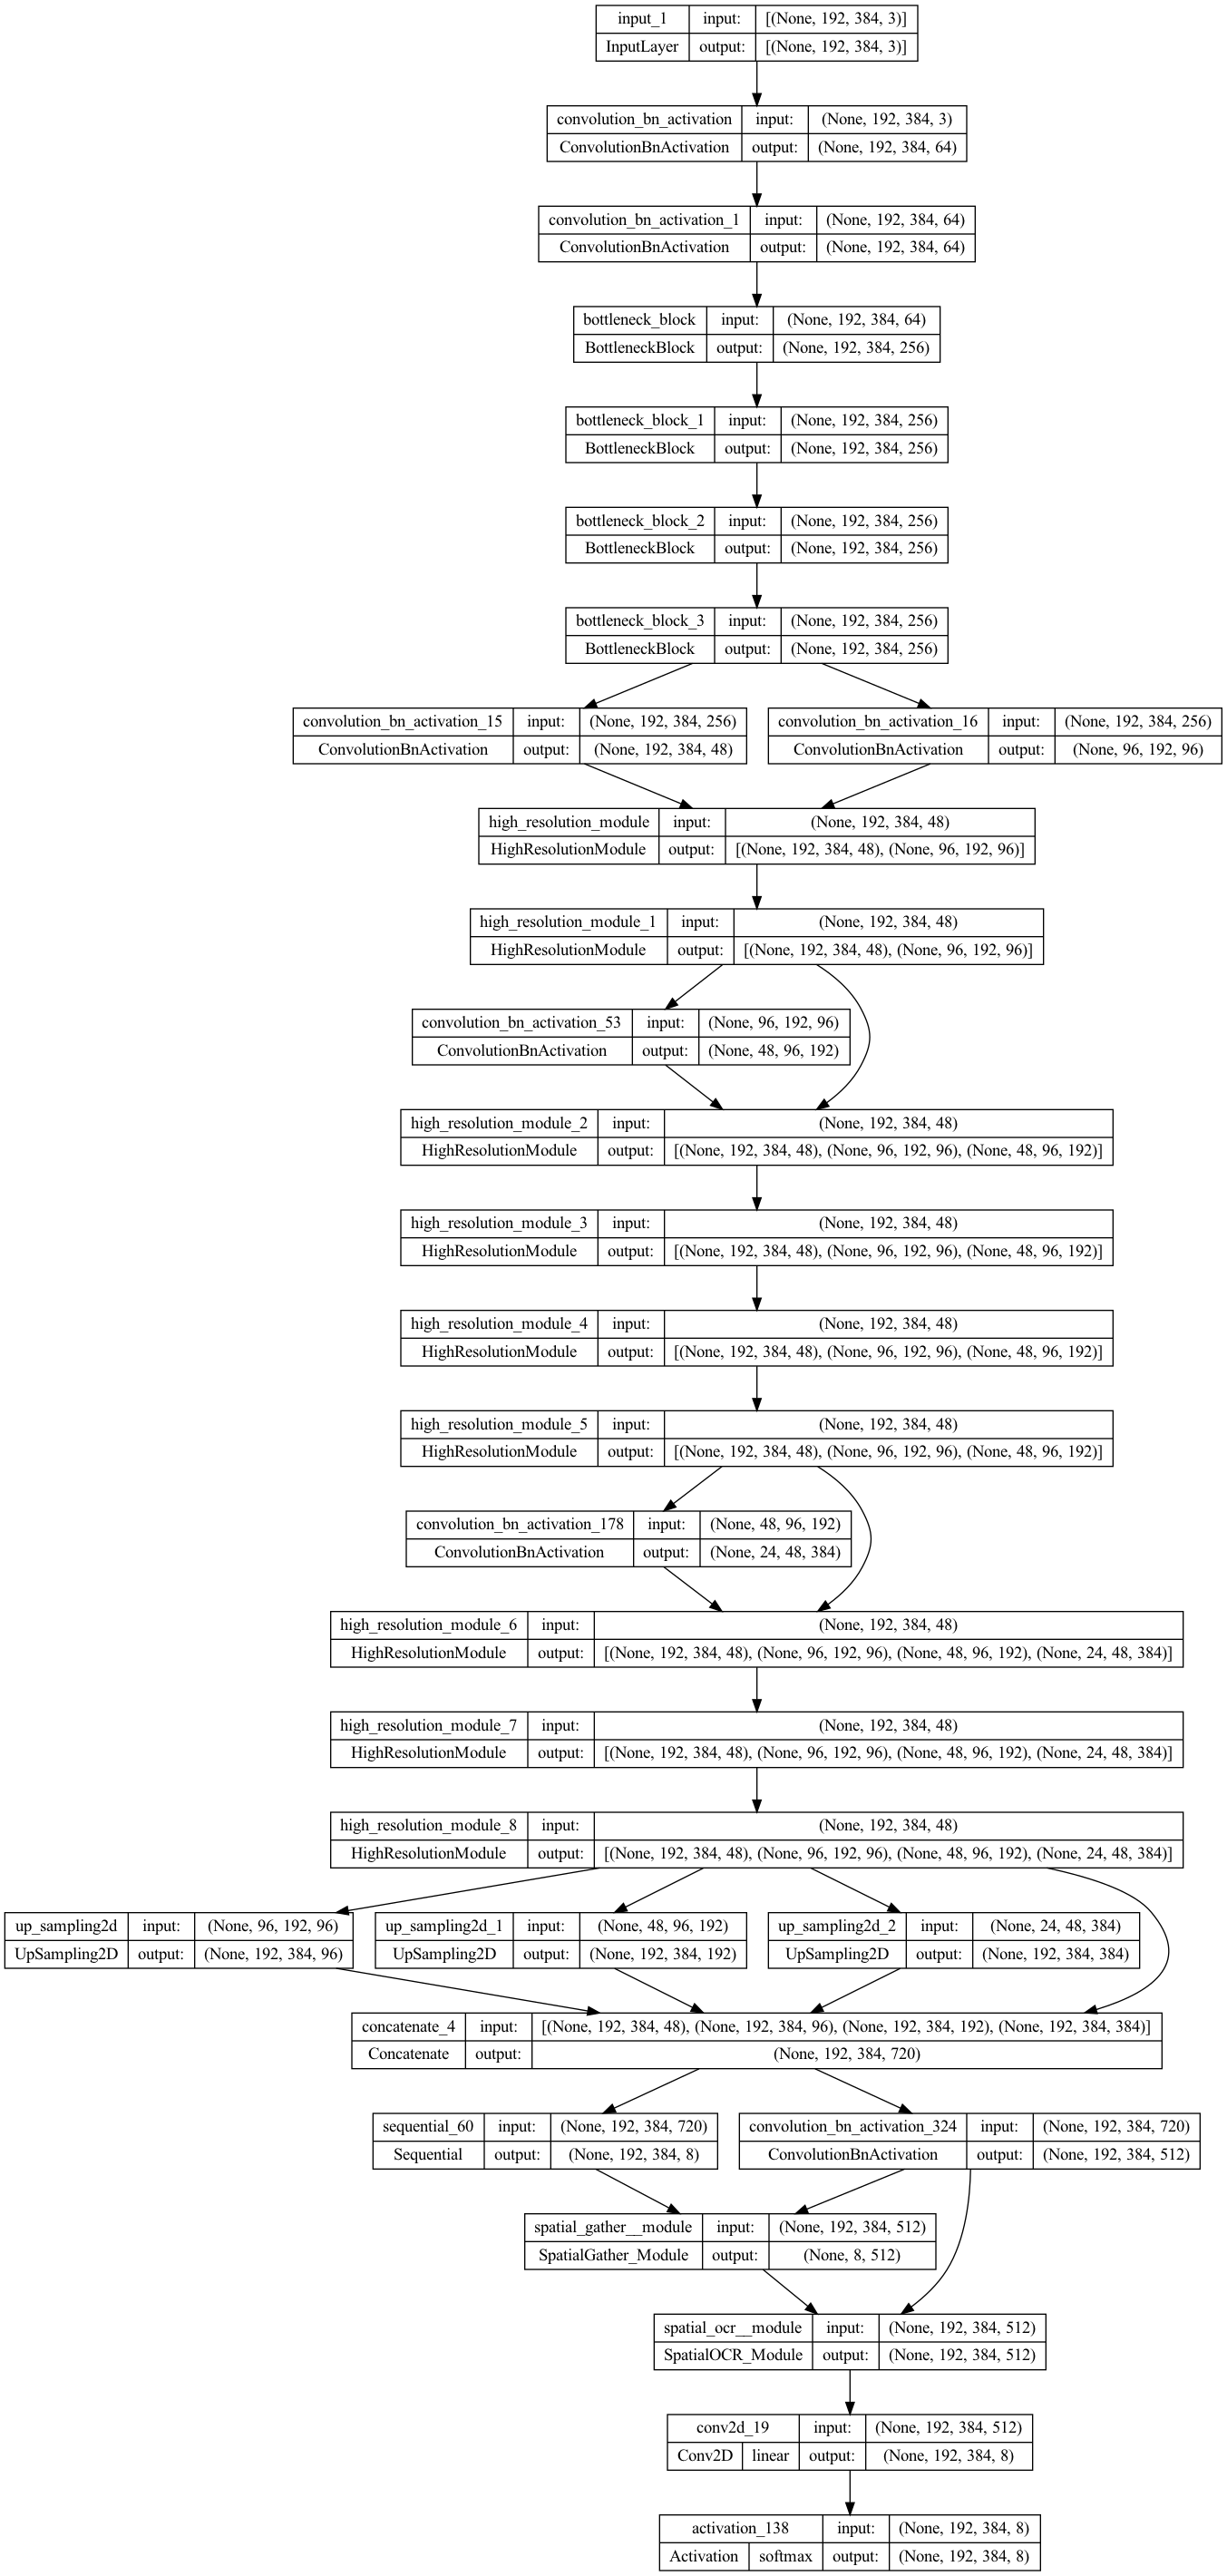

In [28]:
# Plotting the structure of the model and saving it as a PNG image.
plot_model(HRNetOCR_model, to_file="HRNetOCR_model.png", 
           show_shapes=True, show_layer_activations=True)

<h4><div class="alert alert-block alert-warning" id="section_2C2">
2 - Training the model</div></h4>

In [ ]:
%%time
# Training the HRNetOCR model.
hist_model_HRNetOCR = training_model(
    model=HRNetOCR_model, name='model_HRNetOCR',
    epochs=epochs,
    train_gen=train_generator, 
    val_gen=val_generator,
    optimizer=optimizer,
    loss=loss, 
    metrics=[mIoU]
)

No previous checkpoint found. Starting from scratch...

Training the model named 'model_HRNetOCR':

Epoch 1/30


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x4927b0510>
    label = <none> 
    device = <AGXG13XDevice: 0x147d19000>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x110808200>
        label = <none> 
        device = <AGXG13XDevice: 0x147d19000>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x35331e480>
    label = <none> 
    device = <AGXG13XDevice: 0x147d19000>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x110808200>
        label = <none> 
        device = <AGXG13XDevice: 0x147d19000>
            name = Apple M1 Pro 
    r

<h4><div class="alert alert-block alert-warning" id="section_2C3">
3 - Visualization</div></h4>

In [ ]:
# Visualization of the Training and Validation with the iou_score as performance metric.
metrics_visu(hist_model_HRNetOCR, 'iou_score')
# Visualization of the Training and Validation with the Dice Loss function.
loss_visu(hist_model_HRNetOCR, 'dice_loss')

<h3><div class="alert alert-block alert-info" id="section_2D">
D - PERFORMANCE SUMMARY</div></h3>

|Model|Validation Mean IoU|Wall Time|
|:--|:-:|:-:|
|<div style="background: blue; color: white">***U-NET baseline***</div>|<div style="background: blue; color: white">0.5171</div>|0h11|
|<div style="background: green; color: white">***HRNetV2 + OCR***</div>|<div style="background: green; color: white">0.5945</div>|NC|

We can see the performance metrics in the above table, showing that the new SOTA model, **HRnetV2 + OCR, is way better than the "old" U-NET baseline**, by 8 points.<br><br>
Overall the **Mean IoU are not great**, but this is **because of the local training constraints**.<br>
So that our computer doesn't crash, the Jupyter kernel doesn't die, or that we face insufficient computer memory, we had to **downgrade a lot the training conditions**.

<h3><div class="alert alert-block alert-info" id="section_2E">
E - SOME RANDOM MASK PREDICTIONS</div></h3>

In [ ]:
def get_colored(pred_mask, n_classes):
    """Function to get the prediction mask colored as wanted 
    for the different 8 classes."""
    # This color map has been used to display the results in the predicted mask.
    color_map = {
        0: (0, 0, 0),        # void (black)
        1: (160, 120, 50),   # flat (brown)
        2: (255, 200, 200),  # construction (pink)
        3: (255, 255, 120),  # object (yellow)
        4: (0, 150, 40),     # nature (green)
        5: (0, 180, 230),    # sky (sky blue)
        6: (255, 80, 80),    # human (red)
        7: (90, 40, 210)     # vehicule (blue purple)
    }
    
    mask_height = pred_mask.shape[0]
    mask_width = pred_mask.shape[1]
    pred_mask_cls = np.zeros((mask_height, mask_width, 3))

    for cls in range(n_classes):
        pred_mask_rgb = pred_mask[:, :] == cls
        pred_mask_cls[:, :, 0] += (
            (pred_mask_rgb) * (color_map[cls][0])).astype('uint8') # R
        pred_mask_cls[:, :, 1] += (
            (pred_mask_rgb) * (color_map[cls][1])).astype('uint8') # G
        pred_mask_cls[:, :, 2] += (
            (pred_mask_rgb) * (color_map[cls][2])).astype('uint8') # B

    return pred_mask_cls.astype('uint8')

In [ ]:
def mask_prediction(model, img_to_predict, gt_mask):
    """Function that makes the mask prediction with an image.
    Printing of the image, the ground truth mask and the colored prediction mask."""
    
    img_resized = cv2.resize(img_to_predict, (IMG_WIDTH, IMG_HEIGHT))
    pred_mask = model.predict(np.expand_dims(img_resized, axis=0))
    mask = np.squeeze(gt_mask)
    
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = np.squeeze(pred_mask)
    pred_mask_colored = get_colored(pred_mask, 8)
    
    # Visualization of the image, the ground truth mask and the prediction mask.
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Image')
    ax.imshow(img_to_predict)
    
    ax1 = fig.add_subplot(1, 3, 2)
    ax1.set_title('GT_Fine_LabelIds_Mask')
    ax1.imshow(mask)
    ax1.axis('off')
    
    ax2 = fig.add_subplot(1, 3, 3)
    ax2.set_title('Mask prediction')
    ax2.imshow(pred_mask_colored)
    
    return pred_mask_colored

In [ ]:
def run_prediction(img_paths, msk_paths, model):
    """Predicting the mask of 3 random images from a dataset."""
    # Getting 3 random indexes.
    i = random.randint(0, len(img_paths))
    j = random.randint(0, len(img_paths))
    k = random.randint(0, len(img_paths))
    print("i, j, k ", i, j, k)
    # Getting the images and the masks with these indexes in the paths.
    for n in [i, j, k]:
        print("n ", n)
        img_to_predict = img_to_array(
            load_img(img_paths[n])) / 255.0
        if msk_paths:
            gt_mask = img_to_array(
                load_img(msk_paths[n], color_mode="grayscale"))
            gt_mask = np.squeeze(gt_mask)
        else:  # when there is no mask (test dataset), make a all black mask.
            gt_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3))
        mask_prediction(model, img_to_predict, gt_mask)

In [ ]:
# Loading our selected homemade UNET model.
model = load_model("models/model_unet", compile=False)

In [ ]:
# Predicting the mask of 3 random images from the train dataset.
print("\033[34;1mPredicting the mask of 3 random images from the train dataset:\n\n")
run_prediction(image_train_paths_select, mask_train_paths_select, model)

In [ ]:
# Predicting the mask of 3 random images from the validation dataset.
print("\033[34;1mPredicting the mask of 3 random images from the validation dataset:\n\n")
run_prediction(image_val_paths_select, mask_val_paths_select, model)

In [ ]:
# Predicting the mask of 3 random images from the test dataset.
print("\033[34;1mPredicting the mask of 3 random images from the test dataset:\n\n")
run_prediction(image_test_paths, mask_test_paths, model)

<h2><div class="alert alert-block alert-success" id="section_00">
CONCLUSION</div></h2>

Finally, our new SOTA model is way better than the previous one, but with much more time complexity.<br>
Also, we had **divide by 4 the training dataset, put the batch_size to 3, and train on 192 x 384 pixels images ! No wonder the result of the predictions is not very good !**<br><br>
But the **goal of this POC** was not to build the best model, but to find a new one, state-of-the-art, that could **outperform the best model selected for Project 8**.
<br>And so, we did it ! 

**Bibliographic and other references**

• ***Research papers*** :<br>
&emsp;&emsp;º High-Resolution Representations for Labeling Pixels and Regions, published on April 9, 2019 (https://arxiv.org/pdf/1904.04514.pdf).<br>
&emsp;&emsp;º Deep High-Resolution Representation Learning for Visual Recognition, published on March 13, 2020 (https://arxiv.org/pdf/1908.07919.pdf).<br>
&emsp;&emsp;º Segmentation Transformer: Object-Contextual Representations for Semantic Segmentation, published on April 30, 2021 (https://arxiv.org/pdf/1909.11065.pdf).<br>

• ***Jingdong Wang website***, a Principal Research Manager de Microsoft Research Lab - Asia, behind this model:<br>
&emsp;&emsp;https://jingdongwang2017.github.io/Projects/HRNet/

• ***GitHub*** code implementation with PyTorch of the different models based on HRNet: https://github.com/HRNet/HRNet-Semantic-Segmentation

<img src="img_notebook/logo_dataspace.png" width="350" height="350">